# 6
## 6.3
### 6.3.1

wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [1]:
# List 6-28

import os

data_dir='/home/takao/Documents/dev/jupyter/DL-By-Python-Keras/6-jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
# List 6-29

import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i,:] = values

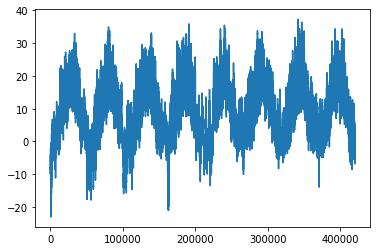

In [3]:
# List 6-30

from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:,1]
plt.plot(range(len(temp)), temp)
plt.show()

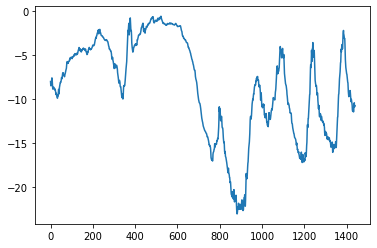

In [4]:
# List 6-31

plt.plot(range(1440), temp[:1440])
plt.show()

In [5]:
# List 6-32

mean = float_data[:20000].mean(axis=0)
float_data -= mean
std = float_data[:20000].std(axis=0)
float_data /= std

In [6]:
# List 6-33

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index,
                                     size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indeces = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indeces]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [7]:
# List 6-34

lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

### 6.3.3

In [8]:
# List 6-35

def evaluate_naive_method():
    batch_maes = []
    for steps in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [9]:
evaluate_naive_method()

0.33551756286169604


In [10]:
# List 6-36

print(0.29 * std[1])
celsius_mae = 0.34 * std[1]
celsius_mae

2.216925247668638


2.59915373864599

### 6.3.4

In [11]:
# List 6-37

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

W0915 12:34:05.272519 140538869776512 deprecation.py:506] From /home/takao/.pyenv/versions/3.7.4/envs/Jupyter/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/20
500/500 [==============================] - 10s 20ms/step - loss: 0.9925 - val_loss: 0.7146
Epoch 2/20
500/500 [==============================] - 9s 18ms/step - loss: 0.4436 - val_loss: 0.3756
Epoch 3/20
500/500 [==============================] - 9s 17ms/step - loss: 0.3313 - val_loss: 0.4412
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2995 - val_loss: 0.3862
Epoch 5/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2813 - val_loss: 0.3692
Epoch 6/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2702 - val_loss: 0.4020
Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2599 - val_loss: 0.3750
Epoch 8/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2527 - val_loss: 0.3979
Epoch 9/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2479 - val_loss: 0.3722
Epoch 10/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2440 - val_l

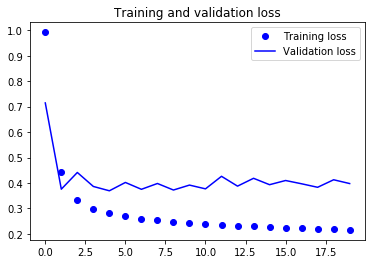

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 6.3.5

In [13]:
# List 6-39

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


W0915 12:37:08.110175 140538869776512 deprecation.py:323] From /home/takao/.pyenv/versions/3.7.4/envs/Jupyter/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


500/500 [==============================] - 117s 234ms/step - loss: 0.3495 - val_loss: 0.3150
Epoch 2/20
500/500 [==============================] - 119s 237ms/step - loss: 0.3324 - val_loss: 0.3080
Epoch 3/20
500/500 [==============================] - 119s 238ms/step - loss: 0.3266 - val_loss: 0.3108
Epoch 4/20
500/500 [==============================] - 120s 240ms/step - loss: 0.3182 - val_loss: 0.3148
Epoch 5/20
500/500 [==============================] - 122s 244ms/step - loss: 0.3134 - val_loss: 0.3077
Epoch 6/20
500/500 [==============================] - 118s 236ms/step - loss: 0.3066 - val_loss: 0.3055
Epoch 7/20
500/500 [==============================] - 118s 236ms/step - loss: 0.3023 - val_loss: 0.3125
Epoch 8/20
500/500 [==============================] - 116s 232ms/step - loss: 0.2980 - val_loss: 0.3095
Epoch 9/20
500/500 [==============================] - 128s 255ms/step - loss: 0.2927 - val_loss: 0.3133
Epoch 10/20
500/500 [==============================] - 122s 244ms/step - lo

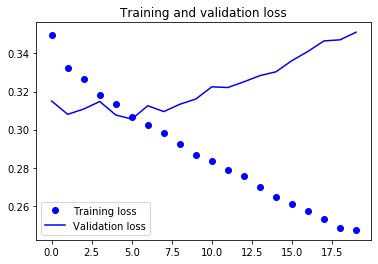

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 6.3.6

In [19]:
# List 6-40

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 135s 270ms/step - loss: 0.3996 - val_loss: 0.3219
Epoch 2/40
500/500 [==============================] - 140s 280ms/step - loss: 0.3657 - val_loss: 0.3225
Epoch 3/40
500/500 [==============================] - 150s 300ms/step - loss: 0.3561 - val_loss: 0.3160
Epoch 4/40
500/500 [==============================] - 137s 275ms/step - loss: 0.3490 - val_loss: 0.3148
Epoch 5/40
500/500 [==============================] - 136s 271ms/step - loss: 0.3449 - val_loss: 0.3125
Epoch 6/40
500/500 [==============================] - 137s 274ms/step - loss: 0.3400 - val_loss: 0.3138
Epoch 7/40
500/500 [==============================] - 140s 280ms/step - loss: 0.3387 - val_loss: 0.3117
Epoch 8/40
500/500 [==============================] - 142s 284ms/step - loss: 0.3345 - val_loss: 0.3111
Epoch 9/40
500/500 [==============================] - 132s 264ms/step - loss: 0.3328 - val_loss: 0.3111
Epoch 10/40
500/500 [==============================] - 142s 284m

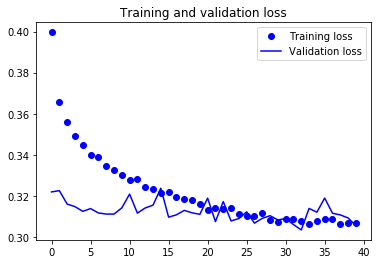

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 6.3.7

In [13]:
# List 6-41

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64,
                     activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, 
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

W0916 15:59:21.969240 140055197462656 deprecation.py:506] From /home/takao/.pyenv/versions/3.7.4/envs/Jupyter/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0916 15:59:22.646015 140055197462656 deprecation.py:323] From /home/takao/.pyenv/versions/3.7.4/envs/Jupyter/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/40
500/500 [==============================] - 281s 563ms/step - loss: 0.3879 - val_loss: 0.3214
Epoch 2/40
500/500 [==============================] - 280s 559ms/step - loss: 0.3602 - val_loss: 0.3311
Epoch 3/40
500/500 [==============================] - 279s 559ms/step - loss: 0.3541 - val_loss: 0.3289
Epoch 4/40
500/500 [==============================] - 284s 569ms/step - loss: 0.3493 - val_loss: 0.3173
Epoch 5/40
500/500 [==============================] - 297s 595ms/step - loss: 0.3425 - val_loss: 0.3206
Epoch 6/40
500/500 [==============================] - 281s 563ms/step - loss: 0.3400 - val_loss: 0.3121
Epoch 7/40
500/500 [==============================] - 276s 553ms/step - loss: 0.3342 - val_loss: 0.3190
Epoch 8/40
500/500 [==============================] - 295s 590ms/step - loss: 0.3317 - val_loss: 0.3348
Epoch 9/40
500/500 [==============================] - 306s 611ms/step - loss: 0.3295 - val_loss: 0.3176
Epoch 10/40
500/500 [==============================] - 289s 579m

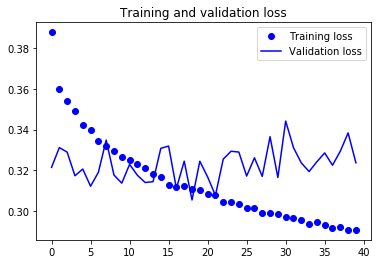

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()